# fit.kn2all.ipynb
- fitting kilonova observational data to the other models

In [63]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import sncosmo

In [64]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [65]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_7dt_depth
from helper import get_7dt_broadband_depth

from helper import get_speclite_lsst
lsst = get_speclite_lsst()
lsstlam = lsst.effective_wavelengths
from helper import get_lsst_depth
from helper import get_kmtnet_depth
from helper import get_lsst_bandwidth
lsstbdw = get_lsst_bandwidth()

In [66]:
from scipy.optimize import curve_fit
def func(x, a):
	return a*x
def calc_chisquare(obs, exp):
	return np.sum((obs-exp)**2/exp)

In [67]:
# magoffset = -2.5*np.log10(54)
magoffset = -4.3
print(f"Apply magnitude offset ({magoffset:1.3f} mag)")

Apply magnitude offset (-4.300 mag)


In [68]:
ii = 0
snsimphtmedlist = sorted(glob.glob('../3.table/sn_sim_sncosmo_synphot/*_med.ecsv'))
snsimphtmed = snsimphtmedlist[ii]
simtbl = ascii.read(snsimphtmed)
# simtbl[:10]

In [69]:
d = 40

jj = 0
knobsphtmedlist = sorted(glob.glob("../5.result/kn_sim_cube_obs/med_iter100_40Mpc/Run*med.ecsv"))
knobsphtmed = knobsphtmedlist[jj]
obstbl = ascii.read(knobsphtmed)
# obstbl[:10]

- Fix single case

In [70]:
t = 1.0
seed = 1
#	Part obs. Table
pobstbl = obstbl[
	(obstbl['t']==t) &
	(obstbl['seed']==seed)
]
# pobstbl

In [71]:
psimtbl = simtbl[
	#	Kilonova
	# (simtbl['t']==1.0)
	#	Supernova Type Ia
	(simtbl['t']==10)
]
# psimtbl

In [72]:
def extract_fnu_from_simulation(psimtbl):
	fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if 'm' in filte]
	return fnuabs

def extract_fnu_anwr_from_observation(pobstbl):
	fnuabs_anwr = [(pobstbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in pobstbl.keys() if 'magabs' in filte]
	return fnuabs_anwr

def extract_fnu_from_observation(pobstbl):
	fnuobs = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuobs_' in filte]
	fnuobserr = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuerr_' in filte]
	return fnuobs, fnuobserr

In [73]:
# #	Simulation (Comparison) Table
# fnuabs = [(psimtbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in psimtbl.keys() if 'm' in filte]
# #	Answer
# fnuabs_anwr = [(pobstbl[f"{filte}"].item()*u.ABmag).to(u.uJy).value for filte in pobstbl.keys() if 'magabs' in filte]
# #	Observation Table
# fnuobs = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuobs_' in filte]
# fnuobserr = [pobstbl[f"{filte}"].item() for filte in pobstbl.keys() if 'fnuerr_' in filte]

In [74]:
fnuabs = extract_fnu_from_simulation(psimtbl)
fnuabs_anwr = extract_fnu_anwr_from_observation(pobstbl)
fnuobs, fnuobserr = extract_fnu_from_observation(pobstbl)

In [75]:
popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
popt_anwr, pcov_anwr = curve_fit(func, fnuabs_anwr, fnuobs, sigma=fnuobserr, absolute_sigma=True,)

In [76]:
chisq = calc_chisquare(
	# obs=func(fnuabs, *popt),
	obs=fnuabs*popt,
	exp=fnuobs,
	)

chisq_anwr = calc_chisquare(
	# obs=func(fnuabs, *popt),
	obs=fnuabs_anwr*popt_anwr,
	exp=fnuobs,
	)

- plot

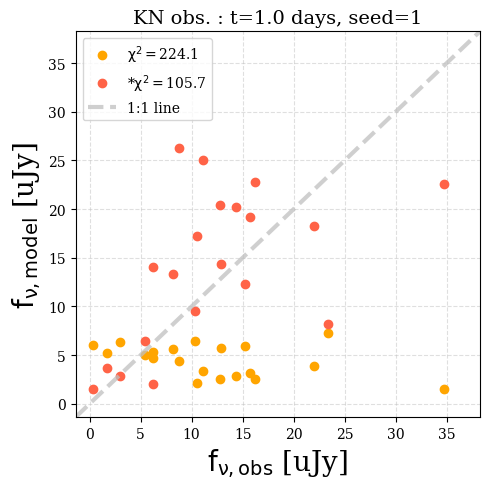

In [77]:
fig = plt.figure(figsize=(5, 5))
plt.title(f"KN obs. : t={t:1.1f} days, seed={seed}")
plt.plot(fnuobs, fnuabs*popt, ls='none', c='orange', marker='o', label=r'$\rm \chi^{2}=$'+f'{chisq:1.1f}')
plt.plot(fnuobs, fnuabs_anwr*popt_anwr, ls='none', c='tomato', marker='o', label=r'*$\rm \chi^{2}=$'+f'{chisq_anwr:1.1f}')

xl, xr = plt.xlim()
plt.xlim([xl, xr*1.05])
plt.ylim([xl, xr*1.05])

plt.plot([xl, xr*1.1], [xl, xr*1.1], ls='--', color='silver', lw=3, label='1:1 line', alpha=0.75)
plt.legend()
plt.xlabel(r'$\rm f_{\nu, obs}$ [uJy]')
plt.ylabel(r'$\rm f_{\nu, model}$ [uJy]')
plt.tight_layout()
plt.grid('both', ls='--', c='silver', alpha=0.5)

# Make color table

In [78]:
bd0 = 'm475'
bd1 = 'm625'
bd2 = 'm750'

tablelist = []

# snclrtbl = Table()
# snclrtbl['model'] = snsimphtmedlist
# snclrtbl[f'{bd0}-{bd1}'] = 0.0
# snclrtbl[f'{bd1}-{bd2}'] = 0.0

#	Comparison
for nn, snsimphtmed in enumerate(snsimphtmedlist):
	simtbl = ascii.read(snsimphtmed)
	times_sim = np.unique(simtbl['t'])

	_ = Table()
	_['model name'] = [snsimphtmed]*len(times_sim)
	_['t'] = times_sim
	_['z'] = simtbl.meta['z']
	grmed_cmp = simtbl[bd0]-simtbl[bd1]
	rimed_cmp = simtbl[bd1]-simtbl[bd2]

	_[f'{bd0}-{bd1}'] = grmed_cmp
	_[f'{bd1}-{bd2}'] = rimed_cmp

	tablelist.append(_)

snclrtbl = vstack(tablelist)
snclrtbl[:5]

model name,t,z,m475-m625,m625-m750
,d,,mag(AB),mag(AB)
str91,float64,float64,float64,float64
../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_med.ecsv,-5.0,0.0001,-0.164,-0.364
../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_med.ecsv,0.0,0.0001,-0.103,-0.711
../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_med.ecsv,5.0,0.0001,-0.097,-0.865
../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_med.ecsv,10.0,0.0001,-0.118,-0.852
../3.table/sn_sim_sncosmo_synphot/hsiao_v3.0_type_Ia_sn_z0.0001_synphot_med.ecsv,15.0,0.0001,-0.061,-0.648


In [79]:
snclrtbl.write(f"../3.table/sn.sncosmo.med.color.ecsv", format='ascii.ecsv', overwrite=True)

In [80]:
knsimphtmedlist = sorted(glob.glob('../3.table/kn_sim_cube_synphot/*_med.ecsv'))
knsimphtmedlist[:3]


['../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_med.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_med.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle150_synphot_med.ecsv']

In [81]:
bd0 = 'm475'
bd1 = 'm625'
bd2 = 'm750'

tablelist = []

#	Comparison
for nn, snsimphtmed in enumerate(knsimphtmedlist):
	print(f"[{nn+1}/{len(knsimphtmedlist)}] {os.path.basename(snsimphtmed)}", end='\r')

	simtbl = ascii.read(snsimphtmed)
	times_sim = np.unique(simtbl['t'])

	_ = Table()
	_['model name'] = [snsimphtmed]*len(times_sim)
	_['t'] = times_sim
	_['z'] = 0.0
	grmed_cmp = simtbl[bd0]-simtbl[bd1]
	rimed_cmp = simtbl[bd1]-simtbl[bd2]

	_[f'{bd0}-{bd1}'] = grmed_cmp
	_[f'{bd1}-{bd2}'] = rimed_cmp

	tablelist.append(_)

knclrtbl = vstack(tablelist)
knclrtbl[:5]

model name,t,z,m475-m625,m625-m750
,d,,mag(AB),mag(AB)
str117,float64,float64,float64,float64
../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_med.ecsv,0.125,0.0,0.723,-0.784
../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_med.ecsv,0.136,0.0,0.227,-0.475
../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_med.ecsv,0.149,0.0,0.004,-0.337
../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_med.ecsv,0.162,0.0,0.110,-0.395
../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_med.ecsv,0.177,0.0,0.217,-0.320


In [82]:
# knclrtbl.write(f"../3.table/kn.sim_cube.color.ecsv", format='ascii.ecsv', overwrite=True)

# Bulk

In [83]:
knobsphtmedlist = sorted(glob.glob("../5.result/kn_sim_cube_obs/med_iter100_40Mpc/Run*med.ecsv"))
snsimphtmedlist = sorted(glob.glob('../3.table/sn_sim_sncosmo_synphot/*_med.ecsv'))

In [84]:
times = np.unique(obstbl['t'])
indx_time = np.array([0, 8, 16, 24, 29, 32, 35, 37])
list(times[indx_time])

[0.125, 0.25, 0.5, 1.0, 1.542, 2.0, 2.594, 3.084]

- g : m475
- r : m625
- i : m750

In [85]:
simtbl.meta

OrderedDict([('classification', 'KN'),
             ('author', 'Wollaeger+21'),
             ('model',
              'Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_spec_2020-02-29.fits'),
             ('shape', 'spherical'),
             ('latitude', 'Edge'),
             ('md', 0.1),
             ('vd', 0.3),
             ('mw', 0.1),
             ('vw', 0.3),
             ('type', 'spec')])

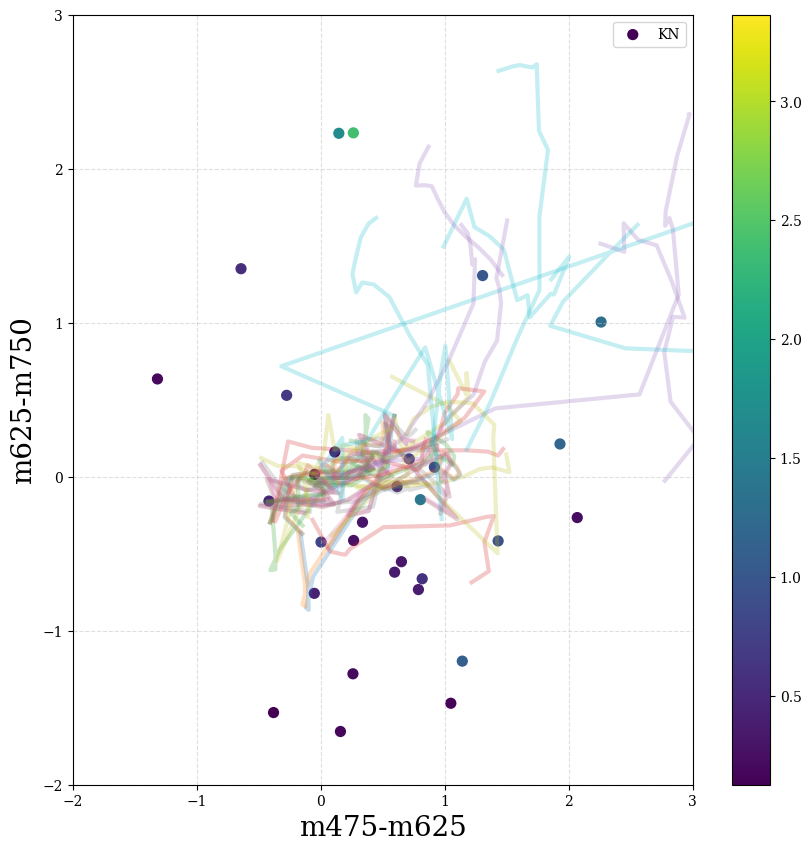

In [86]:
#	Single seed
sobstbl = obstbl[obstbl['seed']==0]

#	g : m475, r : m625, i : m750
#	bd means band
bd0 = 'm475'
bd1 = 'm625'
bd2 = 'm750'

#	Color for obs
grmed = sobstbl[f'magobs_{bd0}']-sobstbl[f'magobs_{bd1}']
rimed = sobstbl[f'magobs_{bd1}']-sobstbl[f'magobs_{bd2}']

times = np.unique(sobstbl['t'])
colors = makeSpecColors(len(grmed))

fig = plt.figure(figsize=(10, 10))

#	Comparison
for nn, snsimphtmed in enumerate(snsimphtmedlist):
	simtbl = ascii.read(snsimphtmed)
	grmed_cmp = simtbl[bd0]-simtbl[bd1]
	rimed_cmp = simtbl[bd1]-simtbl[bd2]
	plt.plot(grmed_cmp, rimed_cmp, lw=3, alpha=0.25)#, label=simtbl.meta['type'])

#	Kilonova
plt.scatter(grmed, rimed, c=times, marker='o', s=50, alpha=1.0, label='KN')
cbar = plt.colorbar()

#	Setting
plt.xlim([-2, 3])
plt.ylim([-2, 3])

plt.legend(ncol=4)
plt.xlabel('m475-m625')
plt.ylabel('m625-m750')
plt.grid('both', ls='--', c='silver', alpha=0.5)

- select similar color

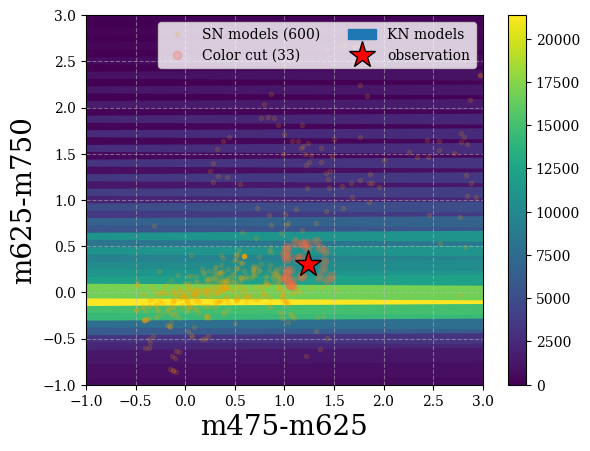

In [87]:
knobsphtmed = knobsphtmedlist[-4]
obstbl = ascii.read(knobsphtmed)

t = 1.0
seed = 0.0

pobstbl = obstbl[
	(obstbl['t']==t) &
	(obstbl['seed']==seed)
]

gr = (pobstbl[f'magobs_{bd0}']-pobstbl[f'magobs_{bd1}']).item()
ri = (pobstbl[f'magobs_{bd1}']-pobstbl[f'magobs_{bd2}']).item()

# print(gr, ri)

#	Color tolerence
colortol = 0.25

indx_clr = np.where(
	(snclrtbl[f"{bd0}-{bd1}"]>gr-colortol) &
	(snclrtbl[f"{bd0}-{bd1}"]<gr+colortol) &
	(snclrtbl[f"{bd1}-{bd2}"]>ri-colortol) &
	(snclrtbl[f"{bd1}-{bd2}"]<ri+colortol)
)

# snclrtbl[indx_clr]

plt.plot(snclrtbl[f"{bd0}-{bd1}"], snclrtbl[f"{bd1}-{bd2}"], ls='none', marker='.', c='orange', alpha=0.125, label=f'SN models ({len(snclrtbl)})')
plt.plot(snclrtbl[f"{bd0}-{bd1}"][indx_clr], snclrtbl[f"{bd1}-{bd2}"][indx_clr], ls='none', marker='o', c='tomato', alpha=0.25, label=f'Color cut ({len(snclrtbl[indx_clr])})')

plt.hexbin(knclrtbl[f"{bd0}-{bd1}"], knclrtbl[f"{bd1}-{bd2}"], gridsize=70, label='KN models')
cbar = plt.colorbar()
# plt.plot(knclrtbl[f"{bd0}-{bd1}"], knclrtbl[f"{bd1}-{bd2}"], ls='none', marker='.', c='green', alpha=0.125, label=f'All ({len(knclrtbl)})')
# plt.plot(knclrtbl[f"{bd0}-{bd1}"][indx_clr], knclrtbl[f"{bd1}-{bd2}"][indx_clr], ls='none', marker='o', alpha=0.125, label=f'Color cut ({len(snclrtbl[indx_clr])})')


plt.plot(gr, ri, marker='*', mec='k', ms=20, color='red', ls='none', label='observation')
plt.legend(ncol=2)
plt.xlim([-1, 3])
plt.ylim([-1, 3])
plt.xlabel('m475-m625')
plt.ylabel('m625-m750')
plt.grid('both', ls='--', c='silver', alpha=0.5)

In [88]:
times = np.unique(obstbl['t'])
indx_time = np.array([0, 8, 16, 24,])
list(times[indx_time])

[0.125, 0.25, 0.5, 1.0]

## Test

In [89]:
d = 40
colortol = 0.25
timetol = 0.05

fittablelist = []
# for jj, knobsphtmed in enumerate(knobsphtmedlist[-16:-8]):
for jj, knobsphtmed in enumerate(knobsphtmedlist[-9:-8]):

	obstbl = ascii.read(knobsphtmed)
	seeds = np.unique(obstbl['seed'])
	times = np.unique(obstbl['t'])

	ss = 0
	seed = seeds[ss]
	#	Save the fitting result
	tmptbl = Table()
	tmptbl['seed'] = [seed]*len(times[indx_time])
	tmptbl['obs'] = os.path.basename(knobsphtmed)
	tmptbl['t'] = times[indx_time]
	##	Empty Table
	###	KN
	tmptbl['kn_bestfit'] = ' '*200
	tmptbl['kn_t'] = 0.0
	tmptbl['kn_chisq'] = 0.0
	tmptbl['kn_popt'] = 0.0
	###	SN
	tmptbl['sn_bestfit'] = ' '*200
	tmptbl['sn_t'] = 0.0
	tmptbl['sn_chisq'] = 0.0
	tmptbl['sn_popt'] = 0.0
	###
	tmptbl['identification'] = False

	ntimes = times[indx_time]
	# tt = 0
	# t = ntimes[tt]
	for tt, t in enumerate(ntimes):
		pobstbl = obstbl[
			(obstbl['t']==t) &
			(obstbl['seed']==seed)
		]
		#	Fitting for the truth
		fnuabs_anwr0 = extract_fnu_anwr_from_observation(pobstbl)
		fnuobs0, fnuobserr0 = extract_fnu_from_observation(pobstbl)
		popt_anwr, pcov_anwr = curve_fit(func, fnuabs_anwr, fnuobs, sigma=fnuobserr, absolute_sigma=True,)

		chisq_anwr = calc_chisquare(
			obs=fnuabs_anwr0*popt_anwr,
			exp=fnuobs0,
		)

		#	Color cut
		gr = (pobstbl[f'magobs_{bd0}']-pobstbl[f'magobs_{bd1}']).item()
		ri = (pobstbl[f'magobs_{bd1}']-pobstbl[f'magobs_{bd2}']).item()
		#	Color tolerence
		##	Other transients
		indx_clr = np.where(
			(snclrtbl[f"{bd0}-{bd1}"]>gr-colortol) &
			(snclrtbl[f"{bd0}-{bd1}"]<gr+colortol) &
			(snclrtbl[f"{bd1}-{bd2}"]>ri-colortol) &
			(snclrtbl[f"{bd1}-{bd2}"]<ri+colortol)
		)
		sncmpmodels = snclrtbl['model name'][indx_clr]
		sncmptimes = snclrtbl['t'][indx_clr]

		if len(sncmpmodels) > 0:
			snchisqlist = []
			snpoptlist = []
			for nn, (snsimphtmed, t_sim) in enumerate(zip(sncmpmodels, sncmptimes)):
				simtbl = ascii.read(snsimphtmed)
				times_sim = np.unique(simtbl['t'])
				#	From psimtbl
				psimtbl = simtbl[(simtbl['t']==t_sim)]
				fnuabs = extract_fnu_from_simulation(psimtbl)
				#	not NaN value
				indx_avail = np.array([i for i, val in enumerate(fnuabs) if not(np.isnan(val))])
				fnuabs = np.array(fnuabs)[indx_avail]
				fnuobs = np.array(fnuobs0)[indx_avail]
				fnuobserr = np.array(fnuobserr0)[indx_avail]
				fnuabs_anwr = np.array(fnuabs_anwr0)[indx_avail]

				popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
				chisq = calc_chisquare(
					obs=fnuabs*popt,
					exp=fnuobs,
					)
				snchisqlist.append(chisq)
				snpoptlist.append(popt[0])
			#	Find best-fit
			snchisqarr = np.array(snchisqlist)
			snchisqmin = snchisqarr.min()
			snbestmdl = sncmpmodels[snchisqarr==snchisqmin].item()
			snbestt = sncmptimes[snchisqarr==snchisqmin].item()
			snpopt = np.array(snpoptlist)[snchisqarr==snchisqmin].item()
		else:
			snchisqmin = None
			snbestmdl = None
			snbestt = None
			snpopt = None

		##	Kilonova
		indx_clr = np.where(
			(knclrtbl[f"{bd0}-{bd1}"]>gr-colortol) &
			(knclrtbl[f"{bd0}-{bd1}"]<gr+colortol) &
			(knclrtbl[f"{bd1}-{bd2}"]>ri-colortol) &
			(knclrtbl[f"{bd1}-{bd2}"]<ri+colortol) &
			(knclrtbl["t"]>t-timetol) &
			(knclrtbl["t"]<t+timetol)
		)
		kncmpmodels = knclrtbl['model name'][indx_clr]
		kncmptimes = knclrtbl['t'][indx_clr]

		if len(kncmpmodels) > 0:
			knchisqlist = []
			knpoptlist = []
			for nn, (snsimphtmed, t_sim) in enumerate(zip(kncmpmodels, kncmptimes)):
				simtbl = ascii.read(snsimphtmed)
				times_sim = np.unique(simtbl['t'])
				#	From psimtbl
				psimtbl = simtbl[(simtbl['t']==t_sim)]
				fnuabs = extract_fnu_from_simulation(psimtbl)
				#	not NaN value
				indx_avail = np.array([i for i, val in enumerate(fnuabs) if not(np.isnan(val))])
				fnuabs = np.array(fnuabs)[indx_avail]
				fnuobs = np.array(fnuobs0)[indx_avail]
				fnuobserr = np.array(fnuobserr0)[indx_avail]
				fnuabs_anwr = np.array(fnuabs_anwr0)[indx_avail]

				popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
				chisq = calc_chisquare(
					obs=fnuabs*popt,
					exp=fnuobs,
					)
				knchisqlist.append(chisq)
				knpoptlist.append(popt[0])

			#	Find best-fit
			knchisqarr = np.array(knchisqlist)
			knchisqmin = knchisqarr.min()
			knbestmdl = kncmpmodels[knchisqarr==knchisqmin].item()
			knbestt = kncmptimes[knchisqarr==knchisqmin].item()
			knpopt = np.array(knpoptlist)[knchisqarr==knchisqmin].item()
		else:
			knchisqmin = None
			knbestmdl = None
			knbestt = None
			knpopt = None

		#	KN
		tmptbl['kn_bestfit'][tt] = knbestmdl
		tmptbl['kn_t'][tt] = knbestt
		tmptbl['kn_chisq'][tt] = knchisqmin
		tmptbl['kn_popt'][tt] = knpopt
		#	SN
		tmptbl['sn_bestfit'][tt] = snbestmdl
		tmptbl['sn_t'][tt] = snbestt
		tmptbl['sn_chisq'][tt] = snchisqmin
		tmptbl['sn_popt'][tt] = snpopt
		if (knchisqmin!=None):
			if snchisqmin==None:
				tmptbl['identification'][tt] = True
			elif knchisqmin < snchisqmin:
				tmptbl['identification'][tt] = True
			else:
				pass
		else:
			pass
	fittablelist.append(tmptbl)

KeyboardInterrupt: 

In [ ]:
fitbl = vstack(fittablelist)
fitbl

seed,obs,t,kn_bestfit,kn_t,kn_chisq,kn_popt,sn_bestfit,sn_t,sn_chisq,sn_popt,identification
,,d,,,,,,,,,
int64,str101,float64,str200,float64,float64,float64,str200,float64,float64,float64,bool
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_med_obs_d40_iter100.med.ecsv,0.125,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.001_vd0.15_mw0.03_vw0.05_angle120_synphot_med.ecsv,0.136,84.82590379950284,4.083062404595893e-11,../3.table/sn_sim_sncosmo_synphot/v19-1993j-corr_v1.0_type_IIb_sn_z0.1_synphot_med.ecsv,31.0,90.53901263330584,1.5390991493098678,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_med_obs_d40_iter100.med.ecsv,0.25,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.1_vd0.05_mw0.1_vw0.05_angle0_synphot_med.ecsv,0.273,89.59864576975639,1.9374450975535035e-11,../3.table/sn_sim_sncosmo_synphot/v19-2007gr-corr_v1.0_type_Ic_sn_z0.1_synphot_med.ecsv,8.0,141.5379665316704,1.1050614869326034,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_med_obs_d40_iter100.med.ecsv,0.5,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.03_vd0.3_mw0.1_vw0.05_angle30_synphot_med.ecsv,0.5,63.26263851151358,6.63291251400412e-12,../3.table/sn_sim_sncosmo_synphot/v19-1999em-corr_v1.0_type_IIP_sn_z1.0_synphot_med.ecsv,14.0,70.02579790576762,325.22239880194076,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle60_synphot_med_obs_d40_iter100.med.ecsv,1.0,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.01_vd0.3_mw0.1_vw0.05_angle60_synphot_med.ecsv,1.0,73.43518622429602,1.3964805163715019e-11,../3.table/sn_sim_sncosmo_synphot/v19-2007gr-corr_v1.0_type_Ic_sn_z1.0_synphot_med.ecsv,19.0,1084.949209694132,1811.9388336218578,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_med_obs_d40_iter100.med.ecsv,0.125,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.003_vd0.05_mw0.003_vw0.05_angle90_synphot_med.ecsv,0.125,141.3246456047033,7.016012861195124e-11,../3.table/sn_sim_sncosmo_synphot/v19-2007gr-corr_v1.0_type_Ic_sn_z0.1_synphot_med.ecsv,10.0,95.45159725394173,0.7527770110298664,False
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_med_obs_d40_iter100.med.ecsv,0.25,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.001_vd0.15_mw0.03_vw0.05_angle120_synphot_med.ecsv,0.229,79.54745731329123,3.2779410808474476e-11,../3.table/sn_sim_sncosmo_synphot/v19-2004gt-corr_v1.0_type_Ic_sn_z0.001_synphot_med.ecsv,40.0,27.068030882255645,0.0001409080182964548,False
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_med_obs_d40_iter100.med.ecsv,0.5,../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind1_all_md0.03_vd0.05_mw0.001_vw0.15_angle180_synphot_med.ecsv,0.545,75.69301600205364,6.7588201762790896e-12,../3.table/sn_sim_sncosmo_synphot/v19-1999em-corr_v1.0_type_IIP_sn_z1.0_synphot_med.ecsv,17.0,106.53898594914344,280.286993036091,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_med_obs_d40_iter100.med.ecsv,1.0,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.1_vd0.3_mw0.01_vw0.15_angle180_synphot_med.ecsv,1.0,89.71147741241646,1.569558594351813e-12,../3.table/sn_sim_sncosmo_synphot/v19-2004et-corr_v1.0_type_IIP_sn_z1.0_synphot_med.ecsv,2.0,110.23303849403644,215.89371677926783,True


In [ ]:
# for mdl in np.unique(fitbl['obs']):
# 	pfitbl = fitbl[fitbl['obs']==mdl]

truetbl = fitbl[fitbl['identification'] == True]
falsetbl = fitbl[fitbl['identification'] == False]

true, false = len(truetbl), len(falsetbl)
total = true+false

tfration = true/total

print(tfration)


0.9375


In [ ]:
plt.plot(fitbl['sn_chisq']-fitbl['kn_chisq'], marker='o', ls='none')
plt.axhline(np.median(fitbl['sn_chisq']-fitbl['kn_chisq']), ls='--', lw=3, alpha=0.5)

In [1]:
fitbl

NameError: name 'fitbl' is not defined

## Old version

In [54]:
d = 40
colortol = 0.1
timetol = 0.05

knobsphtmedlist = sorted(glob.glob(f"../5.result/kn_sim_cube_obs/med_iter100_{d}Mpc/Run*med.ecsv"))

fittablelist = []
for jj, knobsphtmed in enumerate(knobsphtmedlist):
	print(f"[{jj+1}/{len(knobsphtmedlist)}] {os.path.basename(knobsphtmed)}", end='\r')

	obstbl = ascii.read(knobsphtmed)
	seeds = np.unique(obstbl['seed'])
	times = np.unique(obstbl['t'])

	for ss, seed in enumerate(seeds[:1]):
		#	Save the fitting result
		tmptbl = Table()
		tmptbl['seed'] = [seed]*len(times[indx_time])
		tmptbl['obs'] = os.path.basename(knobsphtmed)
		tmptbl['t'] = times[indx_time]
		##	Empty Table
		###	KN
		tmptbl['kn_bestfit'] = ' '*200
		tmptbl['kn_t'] = 0.0
		tmptbl['kn_chisq'] = 0.0
		tmptbl['kn_popt'] = 0.0
		###	SN
		tmptbl['sn_bestfit'] = ' '*200
		tmptbl['sn_t'] = 0.0
		tmptbl['sn_chisq'] = 0.0
		tmptbl['sn_popt'] = 0.0
		###
		tmptbl['identification'] = False

		for tt, t in enumerate(times[indx_time]):
			# print(f"SEED {ss} : [{tt+1}/{len(times[indx_time])}] {os.path.basename(knobsphtmed)}", end='\r')
			pobstbl = obstbl[
				(obstbl['t']==t) &
				(obstbl['seed']==seed)
			]
			#	Fitting for the truth
			fnuabs_anwr0 = extract_fnu_anwr_from_observation(pobstbl)
			fnuobs0, fnuobserr0 = extract_fnu_from_observation(pobstbl)
			popt_anwr, pcov_anwr = curve_fit(func, fnuabs_anwr, fnuobs, sigma=fnuobserr, absolute_sigma=True,)

			chisq_anwr = calc_chisquare(
				obs=fnuabs_anwr0*popt_anwr,
				exp=fnuobs0,
			)

			#	Color cut
			gr = (pobstbl[f'magobs_{bd0}']-pobstbl[f'magobs_{bd1}']).item()
			ri = (pobstbl[f'magobs_{bd1}']-pobstbl[f'magobs_{bd2}']).item()
			#	Color tolerence
			##	Other transients
			indx_clr = np.where(
				(snclrtbl[f"{bd0}-{bd1}"]>gr-colortol) &
				(snclrtbl[f"{bd0}-{bd1}"]<gr+colortol) &
				(snclrtbl[f"{bd1}-{bd2}"]>ri-colortol) &
				(snclrtbl[f"{bd1}-{bd2}"]<ri+colortol)
			)
			sncmpmodels = snclrtbl['model name'][indx_clr]
			sncmptimes = snclrtbl['t'][indx_clr]

			if len(sncmpmodels) > 0:
				snchisqlist = []
				snpoptlist = []
				for nn, (snsimphtmed, t_sim) in enumerate(zip(sncmpmodels, sncmptimes)):
					simtbl = ascii.read(snsimphtmed)
					times_sim = np.unique(simtbl['t'])
					#	From psimtbl
					psimtbl = simtbl[(simtbl['t']==t_sim)]
					fnuabs = extract_fnu_from_simulation(psimtbl)
					#	not NaN value
					indx_avail = np.array([i for i, val in enumerate(fnuabs) if not(np.isnan(val))])
					fnuabs = np.array(fnuabs)[indx_avail]
					fnuobs = np.array(fnuobs0)[indx_avail]
					fnuobserr = np.array(fnuobserr0)[indx_avail]
					fnuabs_anwr = np.array(fnuabs_anwr0)[indx_avail]

					popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
					chisq = calc_chisquare(
						obs=fnuabs*popt,
						exp=fnuobs,
						)
					snchisqlist.append(chisq)
					snpoptlist.append(popt[0])
				#	Find best-fit
				snchisqarr = np.array(snchisqlist)
				snchisqmin = snchisqarr.min()
				snbestmdl = sncmpmodels[snchisqarr==snchisqmin].item()
				snbestt = sncmptimes[snchisqarr==snchisqmin].item()
				snpopt = np.array(snpoptlist)[snchisqarr==snchisqmin].item()
			else:
				snchisqmin = None
				snbestmdl = None
				snbestt = None
				snpopt = None

			##	Kilonova
			indx_clr = np.where(
				(knclrtbl[f"{bd0}-{bd1}"]>gr-colortol) &
				(knclrtbl[f"{bd0}-{bd1}"]<gr+colortol) &
				(knclrtbl[f"{bd1}-{bd2}"]>ri-colortol) &
				(knclrtbl[f"{bd1}-{bd2}"]<ri+colortol) &
				(knclrtbl["t"]>t-timetol) &
				(knclrtbl["t"]<t+timetol)
			)
			kncmpmodels = knclrtbl['model name'][indx_clr]
			kncmptimes = knclrtbl['t'][indx_clr]

			if len(kncmpmodels) > 0:
				knchisqlist = []
				knpoptlist = []
				for nn, (snsimphtmed, t_sim) in enumerate(zip(kncmpmodels, kncmptimes)):
					simtbl = ascii.read(snsimphtmed)
					times_sim = np.unique(simtbl['t'])
					#	From psimtbl
					psimtbl = simtbl[(simtbl['t']==t_sim)]
					fnuabs = extract_fnu_from_simulation(psimtbl)
					#	not NaN value
					indx_avail = np.array([i for i, val in enumerate(fnuabs) if not(np.isnan(val))])
					fnuabs = np.array(fnuabs)[indx_avail]
					fnuobs = np.array(fnuobs0)[indx_avail]
					fnuobserr = np.array(fnuobserr0)[indx_avail]
					fnuabs_anwr = np.array(fnuabs_anwr0)[indx_avail]

					popt, pcov = curve_fit(func, fnuabs, fnuobs, sigma=fnuobserr, absolute_sigma=True,)
					chisq = calc_chisquare(
						obs=fnuabs*popt,
						exp=fnuobs,
						)
					knchisqlist.append(chisq)
					knpoptlist.append(popt[0])

				#	Find best-fit
				knchisqarr = np.array(knchisqlist)
				knchisqmin = knchisqarr.min()
				knbestmdl = kncmpmodels[knchisqarr==knchisqmin].item()
				knbestt = kncmptimes[knchisqarr==knchisqmin].item()
				knpopt = np.array(knpoptlist)[knchisqarr==knchisqmin].item()
			else:
				knchisqmin = None
				knbestmdl = None
				knbestt = None
				knpopt = None

			tmptbl['kn_bestfit'][tt] = knbestmdl
			tmptbl['kn_t'][tt] = knbestt
			tmptbl['kn_chisq'][tt] = knchisqmin
			tmptbl['kn_popt'][tt] = knpopt
			#	SN
			tmptbl['sn_bestfit'][tt] = snbestmdl
			tmptbl['sn_t'][tt] = snbestt
			tmptbl['sn_chisq'][tt] = snchisqmin
			tmptbl['sn_popt'][tt] = snpopt
			if (knchisqmin != None):
				if snchisqmin == None:
					tmptbl['identification'][tt] = True
				elif knchisqmin < snchisqmin:
					tmptbl['identification'][tt] = True
				else:
					pass
			else:
				pass
		fittablelist.append(tmptbl)

ValueError: can only convert an array of size 1 to a Python scalar

In [62]:
# sncmpmodels[snchisqarr==snchisqmin].item()

indx = np.where(snchisqarr==snchisqmin)
snchisqarr[indx]
# sncmpmodels[indx]
# sncmptimes[indx]



array([128.1343602, 128.1343602, 128.1343602])

In [52]:
fitbl = vstack(fittablelist)
fitbl

seed,obs,t,kn_bestfit,kn_t,kn_chisq,kn_popt,sn_bestfit,sn_t,sn_chisq,sn_popt,identification
,,d,,,,,,,,,
int64,str100,float64,str200,float64,float64,float64,str200,float64,float64,float64,bool
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.15_angle90_synphot_med_obs_d40_iter100.med.ecsv,0.125,../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.003_vd0.3_mw0.001_vw0.15_angle60_synphot_med.ecsv,0.162,45.885282113843964,8.39677447366775e-12,../3.table/sn_sim_sncosmo_synphot/v19-1993j-corr_v1.0_type_IIb_sn_z0.01_synphot_med.ecsv,4.0,49.847759353527984,0.03524696499497969,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.15_angle90_synphot_med_obs_d40_iter100.med.ecsv,0.25,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.01_vd0.3_mw0.001_vw0.15_angle120_synphot_med.ecsv,0.25,93.79496545502471,8.476303829704742e-12,../3.table/sn_sim_sncosmo_synphot/v19-1993j-corr_v1.0_type_IIb_sn_z0.1_synphot_med.ecsv,9.0,257.4028688579128,8.213615648481335,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.15_angle90_synphot_med_obs_d40_iter100.med.ecsv,0.5,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.01_vd0.3_mw0.01_vw0.15_angle90_synphot_med.ecsv,0.545,92.63647297267669,7.985006810698256e-12,../3.table/sn_sim_sncosmo_synphot/v19-2009ip-corr_v1.0_type_IIn_sn_z1.0_synphot_med.ecsv,-5.0,173.8066563363362,268.1189254514804,True
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.15_angle90_synphot_med_obs_d40_iter100.med.ecsv,1.0,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.03_vd0.3_mw0.01_vw0.15_angle60_synphot_med.ecsv,1.0,142.7248955547551,3.0986818306544452e-12,../3.table/sn_sim_sncosmo_synphot/v19-2009ip-corr_v1.0_type_IIn_sn_z0.0001_synphot_med.ecsv,27.0,122.25580690258924,7.104299835843005e-06,False


In [39]:
# for mdl in np.unique(fitbl['obs']):
# 	pfitbl = fitbl[fitbl['obs']==mdl]

truetbl = fitbl[fitbl['identification'] == True]
falsetbl = fitbl[fitbl['identification'] == False]

true, false = len(truetbl), len(falsetbl)
total = true+false

tfration = true/total

print(tfration)


0.9375


In [50]:
fitbl[fitbl['identification']==False]

seed,obs,t,kn_bestfit,kn_t,kn_chisq,kn_popt,sn_bestfit,sn_t,sn_chisq,sn_popt,identification
,,d,,,,,,,,,
int64,str101,float64,str200,float64,float64,float64,str200,float64,float64,float64,bool
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_med_obs_d40_iter100.med.ecsv,0.125,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.003_vd0.05_mw0.003_vw0.05_angle90_synphot_med.ecsv,0.125,141.3246456047033,7.016012861195124e-11,../3.table/sn_sim_sncosmo_synphot/v19-2007gr-corr_v1.0_type_Ic_sn_z0.1_synphot_med.ecsv,10.0,95.45159725394173,0.7527770110298664,False
0,Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.05_angle90_synphot_med_obs_d40_iter100.med.ecsv,0.25,../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind2_all_md0.001_vd0.15_mw0.03_vw0.05_angle120_synphot_med.ecsv,0.229,79.54745731329123,3.2779410808474476e-11,../3.table/sn_sim_sncosmo_synphot/v19-2004gt-corr_v1.0_type_Ic_sn_z0.001_synphot_med.ecsv,40.0,27.068030882255645,0.0001409080182964548,False


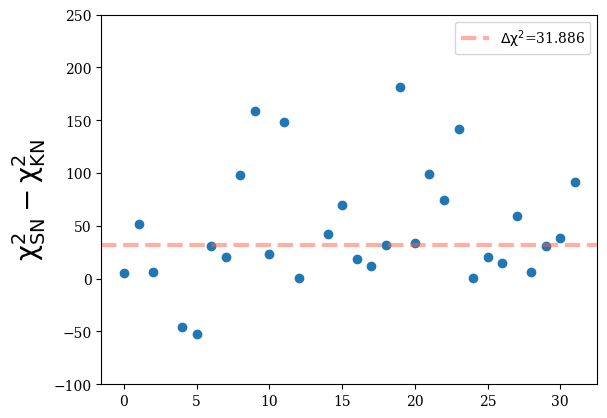

In [45]:
plt.plot(fitbl['sn_chisq']-fitbl['kn_chisq'], marker='o', ls='none')

delchisqs = fitbl['sn_chisq']-fitbl['kn_chisq']
delchisq = np.median([val for val in delchisqs if ~np.isnan(val)])

plt.axhline(delchisq, ls='--', c='tomato', lw=3, alpha=0.5, label=r"$\rm \Delta{\chi^2}$"+f'={delchisq:1.3f}')

plt.ylim(-100, 250)
plt.ylabel(r'$\rm \chi^{2}_{SN}-\chi^{2}_{KN}$')
plt.legend()

In [233]:
gr = (pobstbl[f'magobs_{bd0}']-pobstbl[f'magobs_{bd1}']).item()
ri = (pobstbl[f'magobs_{bd1}']-pobstbl[f'magobs_{bd2}']).item()
#	Color tolerence
##	Other transients
indx_clr = np.where(
	(snclrtbl[f"{bd0}-{bd1}"]>gr-colortol) &
	(snclrtbl[f"{bd0}-{bd1}"]<gr+colortol) &
	(snclrtbl[f"{bd1}-{bd2}"]>ri-colortol) &
	(snclrtbl[f"{bd1}-{bd2}"]<ri+colortol)
)
sncmpmodels = snclrtbl['model name'][indx_clr]
sncmptimes = snclrtbl['t'][indx_clr]

snclrtbl[(snclrtbl[f"{bd0}-{bd1}"]>gr-colortol) & (snclrtbl[f"{bd0}-{bd1}"]<gr+colortol) & (snclrtbl[f"{bd1}-{bd2}"]>ri-colortol) & (snclrtbl[f"{bd1}-{bd2}"]<ri+colortol)]

model name,t,z,m475-m625,m625-m750
,d,,mag(AB),mag(AB)
str91,float64,float64,float64,float64


Truth       : Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_med_obs_d40_iter100.med.ecsv
Best-fit KN : Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.3_mw0.1_vw0.05_angle120_synphot_med.ecsv
Best-fit SN : v19-1993j-corr_v1.0_type_IIb_sn_z0.1_synphot_med.ecsv


seed,t,magabs_m400,magapp_m400,snr_m400,magerr_m400,magobs_m400,fnu_m400,fnuobs_m400,fnuerr_m400,detection_m400,magabs_m425,magapp_m425,snr_m425,magerr_m425,magobs_m425,fnu_m425,fnuobs_m425,fnuerr_m425,detection_m425,magabs_m450,magapp_m450,snr_m450,magerr_m450,magobs_m450,fnu_m450,fnuobs_m450,fnuerr_m450,detection_m450,magabs_m475,magapp_m475,snr_m475,magerr_m475,magobs_m475,fnu_m475,fnuobs_m475,fnuerr_m475,detection_m475,magabs_m500,magapp_m500,snr_m500,magerr_m500,magobs_m500,fnu_m500,fnuobs_m500,fnuerr_m500,detection_m500,magabs_m525,magapp_m525,snr_m525,magerr_m525,magobs_m525,fnu_m525,fnuobs_m525,fnuerr_m525,detection_m525,magabs_m550,magapp_m550,snr_m550,magerr_m550,magobs_m550,fnu_m550,fnuobs_m550,fnuerr_m550,detection_m550,magabs_m575,magapp_m575,snr_m575,magerr_m575,magobs_m575,fnu_m575,fnuobs_m575,fnuerr_m575,detection_m575,magabs_m600,magapp_m600,snr_m600,magerr_m600,magobs_m600,fnu_m600,fnuobs_m600,fnuerr_m600,detection_m600,magabs_m625,magapp_m625,snr_m625,magerr_m625,magobs_m625,fnu_m625,fnuobs_m625,fnuerr_m625,detection_m625,magabs_m650,magapp_m650,snr_m650,magerr_m650,magobs_m650,fnu_m650,fnuobs_m650,fnuerr_m650,detection_m650,magabs_m675,magapp_m675,snr_m675,magerr_m675,magobs_m675,fnu_m675,fnuobs_m675,fnuerr_m675,detection_m675,magabs_m700,magapp_m700,snr_m700,magerr_m700,magobs_m700,fnu_m700,fnuobs_m700,fnuerr_m700,detection_m700,magabs_m725,magapp_m725,snr_m725,magerr_m725,magobs_m725,fnu_m725,fnuobs_m725,fnuerr_m725,detection_m725,magabs_m750,magapp_m750,snr_m750,magerr_m750,magobs_m750,fnu_m750,fnuobs_m750,fnuerr_m750,detection_m750,magabs_m775,magapp_m775,snr_m775,magerr_m775,magobs_m775,fnu_m775,fnuobs_m775,fnuerr_m775,detection_m775,magabs_m800,magapp_m800,snr_m800,magerr_m800,magobs_m800,fnu_m800,fnuobs_m800,fnuerr_m800,detection_m800,magabs_m825,magapp_m825,snr_m825,magerr_m825,magobs_m825,fnu_m825,fnuobs_m825,fnuerr_m825,detection_m825,magabs_m850,magapp_m850,snr_m850,magerr_m850,magobs_m850,fnu_m850,fnuobs_m850,fnuerr_m850,detection_m850,magabs_m875,magapp_m875,snr_m875,magerr_m875,magobs_m875,fnu_m875,fnuobs_m875,fnuerr_m875,detection_m875
,d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),uJy,uJy,uJy,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,f

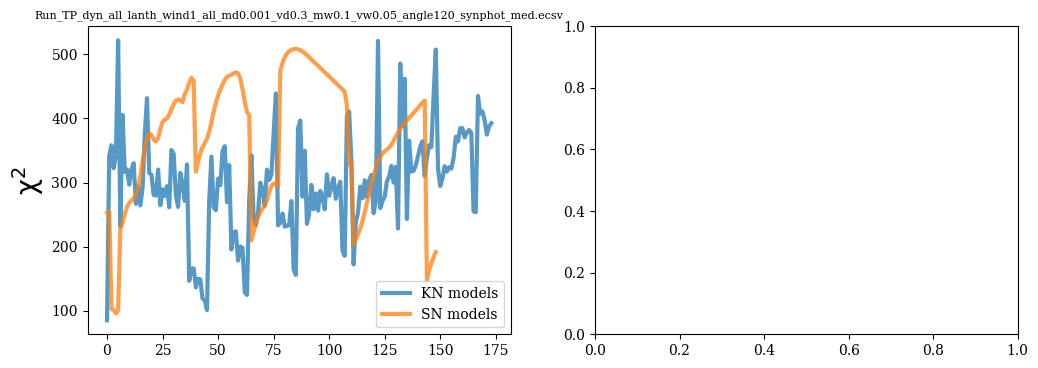

In [221]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(kncmpmodels)), knchisqlist, label='KN models', lw=3, alpha=0.75)
knchisqarr = np.array(knchisqlist)
knchisqmin = knchisqarr.min()
knbestmdl = kncmpmodels[knchisqarr==knchisqmin].item()
plt.title(os.path.basename(knbestmdl), fontsize=8)

#	SN
plt.plot(np.arange(len(sncmpmodels)), snchisqlist, label='SN models', lw=3, alpha=0.75)
snchisqarr = np.array(snchisqlist)
snchisqmin = snchisqarr.min()
snbestmdl = sncmpmodels[snchisqarr==snchisqmin].item()
plt.legend()
plt.ylabel(r"$\rm \chi^2$")

print(f"Truth       : {os.path.basename(knobsphtmed)}")
print(f"Best-fit KN : {os.path.basename(knbestmdl)}")
print(f"Best-fit SN : {os.path.basename(snbestmdl)}")

plt.subplot(1, 2, 2)